In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import kid_readout.roach.heterodyne
import time
import kid_readout.analysis.resonator
import kid_readout.analysis.khalil
import kid_readout.utils.data_file

In [3]:
ri = kid_readout.roach.heterodyne.RoachHeterodyne()

In [4]:
all_resonances = np.array([844.95,
             865.24,
             871.9,
             875.29,
             879.67,
             880.99,
             883.09,
             891.17,
             900.9,
             905.3,
             917.6,
             919.4,
             945.5,
             947.5,
             950.4,
             963.58,
             971.77,
             992.03,
             1002.93,
             1007.93,
             1015.6,
             1019.13,
             1027.3,
             1034.36,
             1039.54,
             ])

In [5]:
initial_f0s = np.concatenate((all_resonances[::2],all_resonances[1::2][0::3]))[:16]
initial_f0s.sort()
initial_f0s

array([  844.95,   865.24,   871.9 ,   879.67,   883.09,   891.17,
         900.9 ,   917.6 ,   945.5 ,   947.5 ,   950.4 ,   971.77,
        1002.93,  1015.6 ,  1027.3 ,  1039.54])

In [6]:
initial_atten = 30
atten_levels = [40,30,20,10,0]

In [7]:
ri.set_lo(930)

In [8]:
ri.set_fft_gain(4)

In [9]:
ri.lo_frequency

930

In [10]:
import kid_readout.utils.sweeps
reload(kid_readout.utils.sweeps)

<module 'kid_readout.utils.sweeps' from '/home/gjones/readout/kid_readout/kid_readout/utils/sweeps.pyc'>

In [11]:
nsamp = 2**16
df = 512./nsamp
kid_readout.utils.sweeps.prepare_sweep(ri,center_freqs=initial_f0s,offsets=np.arange(-64,64)*df,
                                       nsamp=nsamp)


bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([[  844.453125 ,   864.7421875,   871.3984375, ...,  1015.1015625,
         1026.796875 ,  1039.0390625],
       [  844.4609375,   864.75     ,   871.40625  , ...,  1015.109375 ,
         1026.8046875,  1039.046875 ],
       [  844.46875  ,   864.7578125,   871.4140625, ...,  1015.1171875,
         1026.8125   ,  1039.0546875],
       ..., 
       [  845.4296875,   865.71875  ,   872.375    , ...,  1016.078125 ,
         1027.7734375,  1040.015625 ],
       [  845.4375   ,   865.7265625,   872.3828125, ...,  1016.0859375,
         1027.78125  ,  1040.0234375],
       [  845.4453125,   865.734375 ,   872.390625 , ...,  1016.09375  ,
         1027.7890625,  1040.03125  ]])

In [12]:
ri.set_dac_atten(initial_atten)

In [13]:
data_file = kid_readout.utils.data_file.DataFile(suffix='dark')

In [14]:
data_file.log_adc_snap(ri)
data_file.log_hw_state(ri)

In [15]:
tic = time.time()
swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=16)
print time.time()-tic
data_file.add_sweep(swp)

detected mcnt overflow None 1638593 0 32768 0 464 1638593
67.3944041729


'sweep_20150626152051'

In [16]:
def fit_sweeps(swp):
    resonators = []
    lo = swp.blocks[0].lo
    fig,axs = subplots(4,4,figsize=(18,12))
    for k in range(swp.sweep_indexes.max()+1):
        fr,s21,err = swp.select_index(k)
        ax = axs.flatten()[k]
        fr,s21,err = swp.select_index(k)
        s21c = s21*np.exp(swp.hardware_delay_estimate*1e6j*2*np.pi*(fr-swp.lo[0]))
        res = kid_readout.analysis.resonator.fit_best_resonator(fr,s21c,errors=err,min_a=1.0)
        ax.plot(s21c.real,s21c.imag,'.-')
        modl = res.model(x=fr)
        ax.plot(modl.real,modl.imag,'.-')
        resonators.append(res)
    return resonators

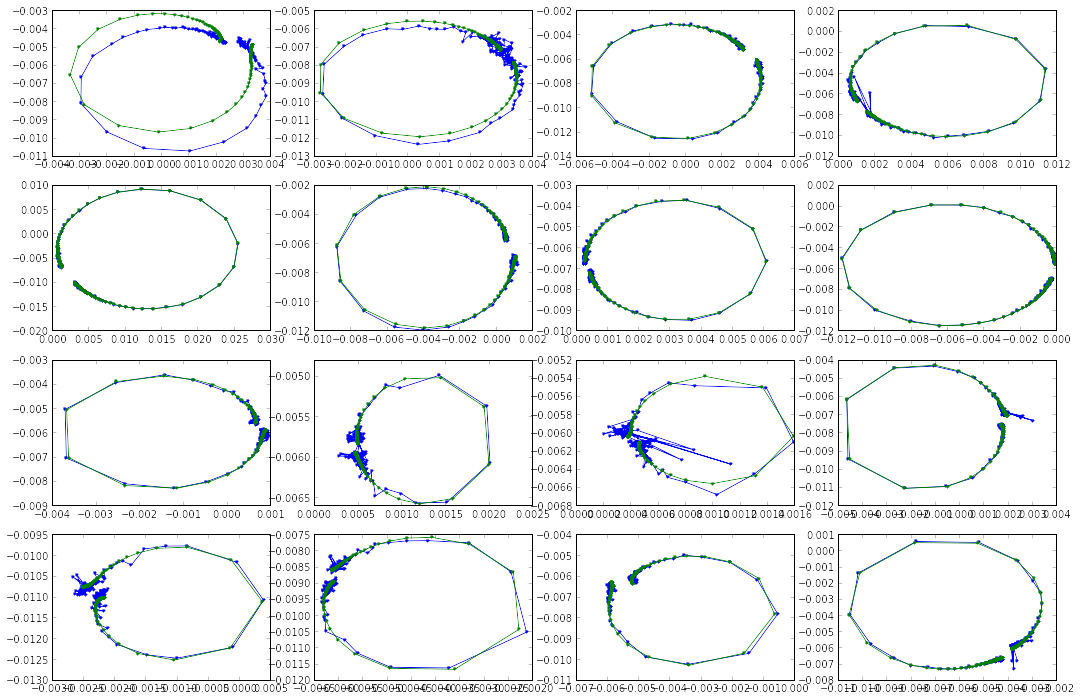

In [17]:
resonators = fit_sweeps(swp)

In [18]:
updated_f0s = np.array([res.f_0 for res in resonators])
Qs = np.array([res.Q for res in resonators])
fwhm = updated_f0s/(2*Qs)
(updated_f0s - initial_f0s)*1e3

array([ -3.94983302,  -8.17106007, -20.75564902,  29.65856568,
        59.82221245, -10.44465195,  43.28350942,   9.35269437,
        10.99529884, -43.46632806,  19.58728024,   6.79439818,
        17.18397551,  -5.7021413 ,  24.80726346,  -4.96122886])

In [19]:
fwhm

array([ 0.02867395,  0.03054224,  0.02808488,  0.02511719,  0.03599935,
        0.03020894,  0.02612501,  0.03061702,  0.01757023,  0.01621178,
        0.01457352,  0.0153143 ,  0.01609951,  0.01650337,  0.01872652,
        0.02050477])

In [20]:
nsamp = 2**18
df = 512./nsamp
kid_readout.utils.sweeps.prepare_sweep(ri,center_freqs=updated_f0s,offsets=np.arange(-64,64)*df,
                                       nsamp=nsamp)

bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0

writing DRAM bank 1



array([[  844.8203125 ,   865.10742188,   871.75390625, ...,
         1015.46875   ,  1027.19921875,  1039.41015625],
       [  844.82226562,   865.109375  ,   871.75585938, ...,
         1015.47070312,  1027.20117188,  1039.41210938],
       [  844.82421875,   865.11132812,   871.7578125 , ...,
         1015.47265625,  1027.203125  ,  1039.4140625 ],
       ..., 
       [  845.06445312,   865.3515625 ,   871.99804688, ...,
         1015.71289062,  1027.44335938,  1039.65429688],
       [  845.06640625,   865.35351562,   872.        , ...,
         1015.71484375,  1027.4453125 ,  1039.65625   ],
       [  845.06835938,   865.35546875,   872.00195312, ...,
         1015.71679688,  1027.44726562,  1039.65820312]])

detected mcnt overflow None 1605819 0 32768 0 176 1605819
detected mcnt overflow None 295102 0 32768 0 432 295102
67.6309399605


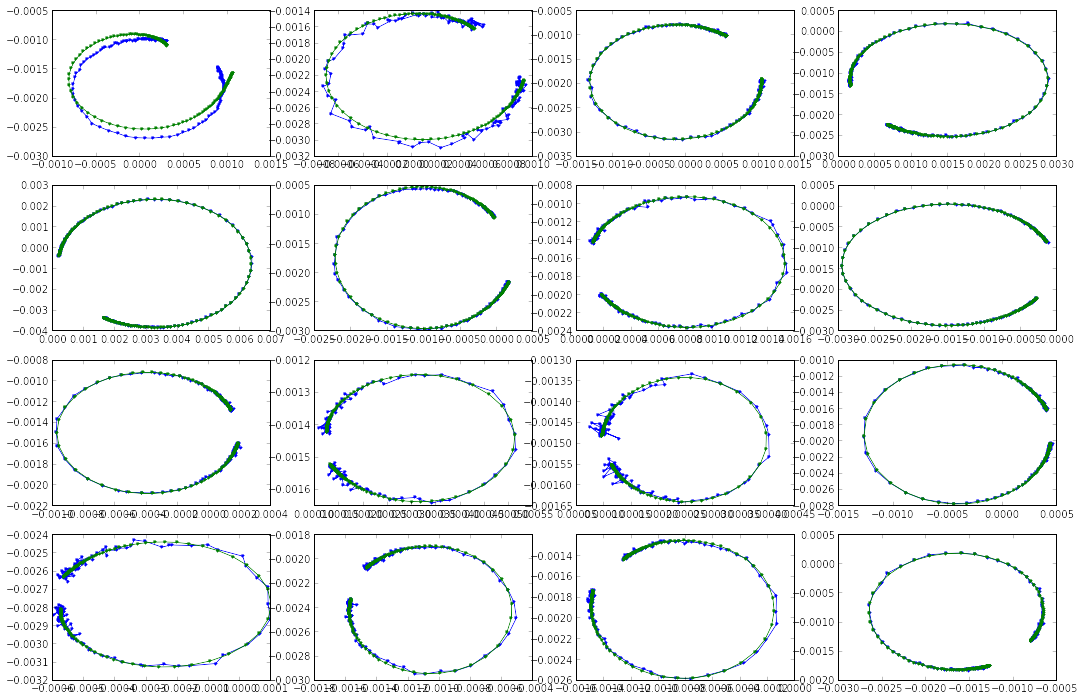

In [21]:
tic = time.time()
fine_swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=16)
print time.time()-tic
new_res = fit_sweeps(fine_swp)
new_f0s = np.array([res.f_0 for res in new_res])

In [22]:
ri.add_tone_freqs(new_f0s)

bank_offset= 2 start_offset= 67108864 start_offset_bytes= 0
writing DRAM bank 2



array([  844.9453125 ,   865.23242188,   871.87890625,   879.69921875,
         883.15039062,   891.16015625,   900.94335938,   917.609375  ,
         945.51171875,   947.45703125,   950.41992188,   971.77734375,
        1002.94726562,  1015.59375   ,  1027.32421875,  1039.53515625])

atten 40
detected mcnt overflow None 426172 0 32768 0 464 426172
detected mcnt overflow None 1343677 0 32768 0 384 1343677
detected mcnt overflow None 1343678 0 32768 0 192 1343678
67.8956251144
difference in resonant frequency, ppm: [-19.79363541  -5.25975451  -0.20704683  -0.12724588   0.10615676
  -0.65037817   2.01829847   0.17882331  -0.07780139   0.07304896
  -1.87165608   0.0718289    0.61410603   0.86734409   0.36130343
   0.28104149]
detected mcnt overflow None 557245 0 32768 0 11216 557245
102.254709005
atten 30
detected mcnt overflow None 164027 0 32768 0 160 164027
detected mcnt overflow None 1474748 0 32768 0 96 1474748
detected mcnt overflow None 32957 0 32768 0 16 32957
67.7809038162
difference in resonant frequency, ppm: [ 0.24549779  0.31263842  0.14772869  0.02031215 -0.01129078  0.16812908
  0.33155077 -0.01138274  0.07118257 -0.22296657  0.45927707  0.03280436
 -0.17551579  0.15806784  0.14608519  0.00078638]
detected mcnt overflow None 426173 0 32768 0 9760 426173


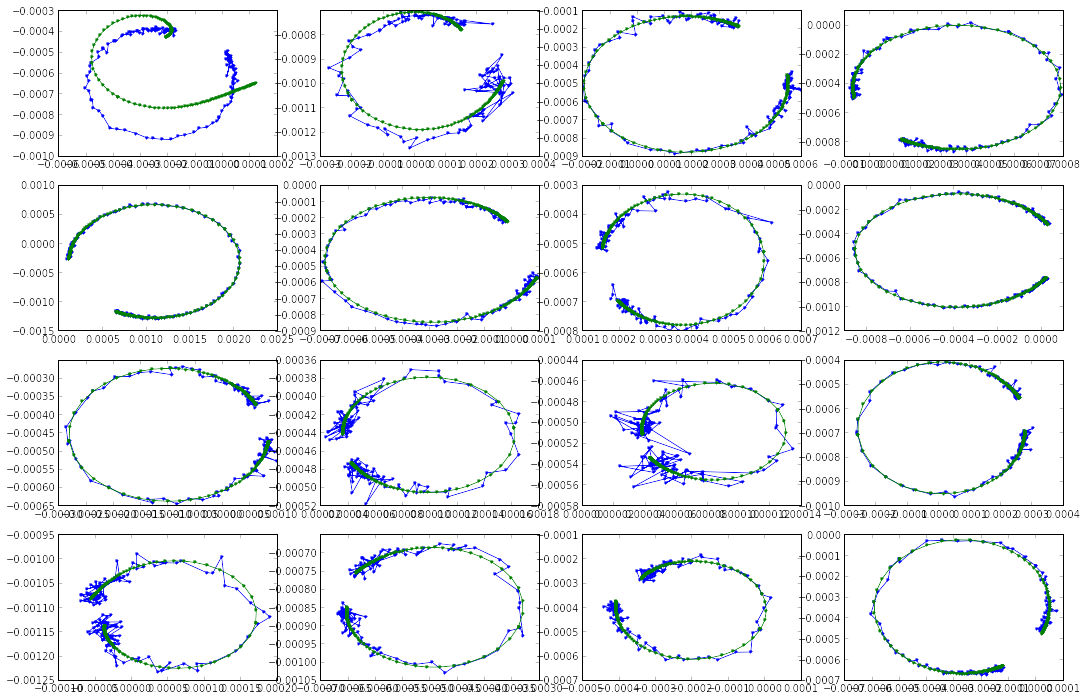

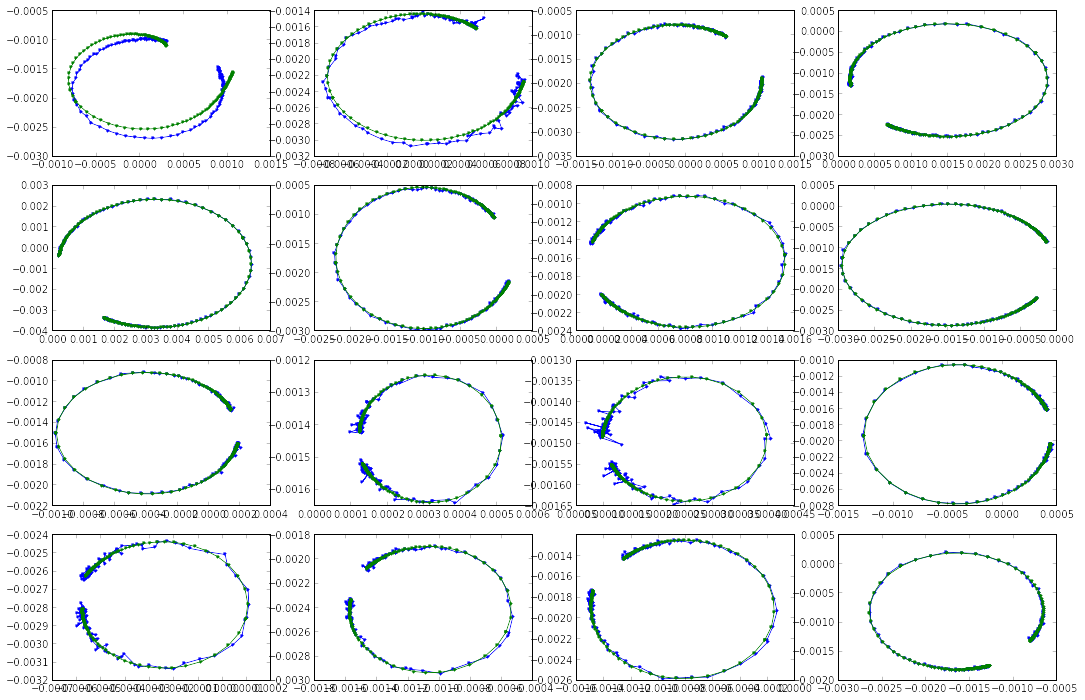

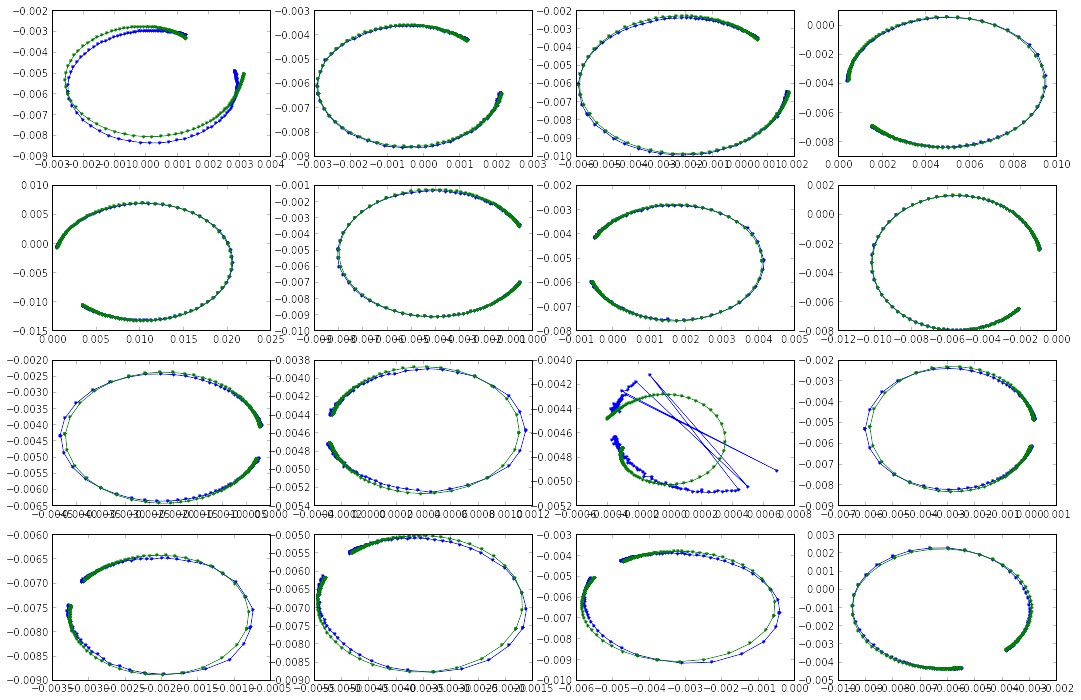

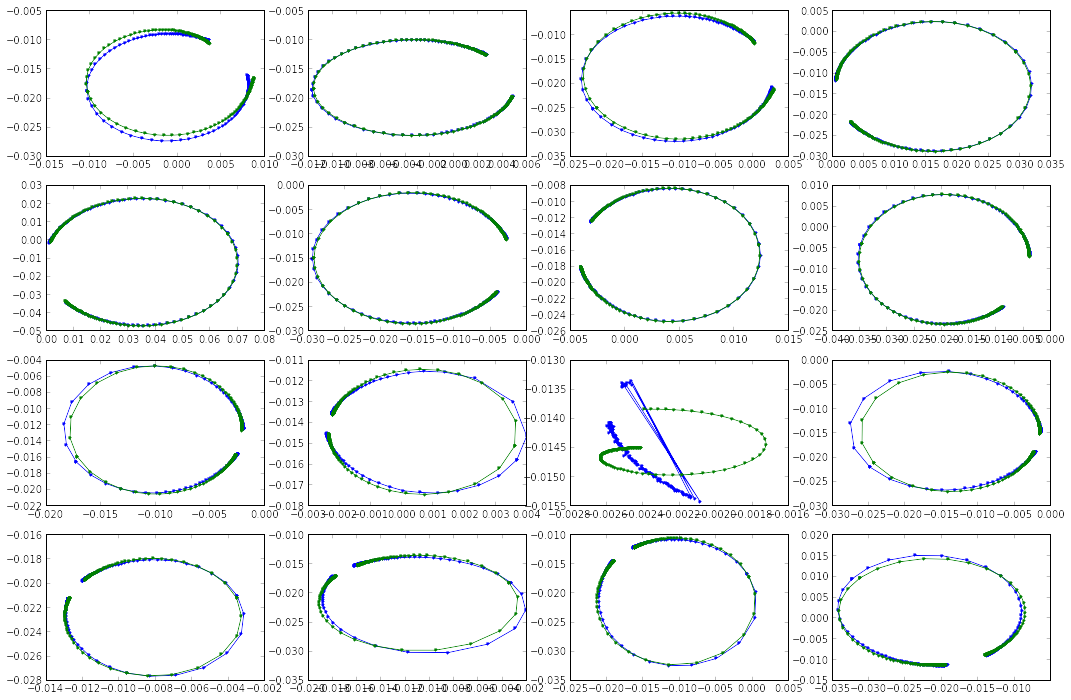

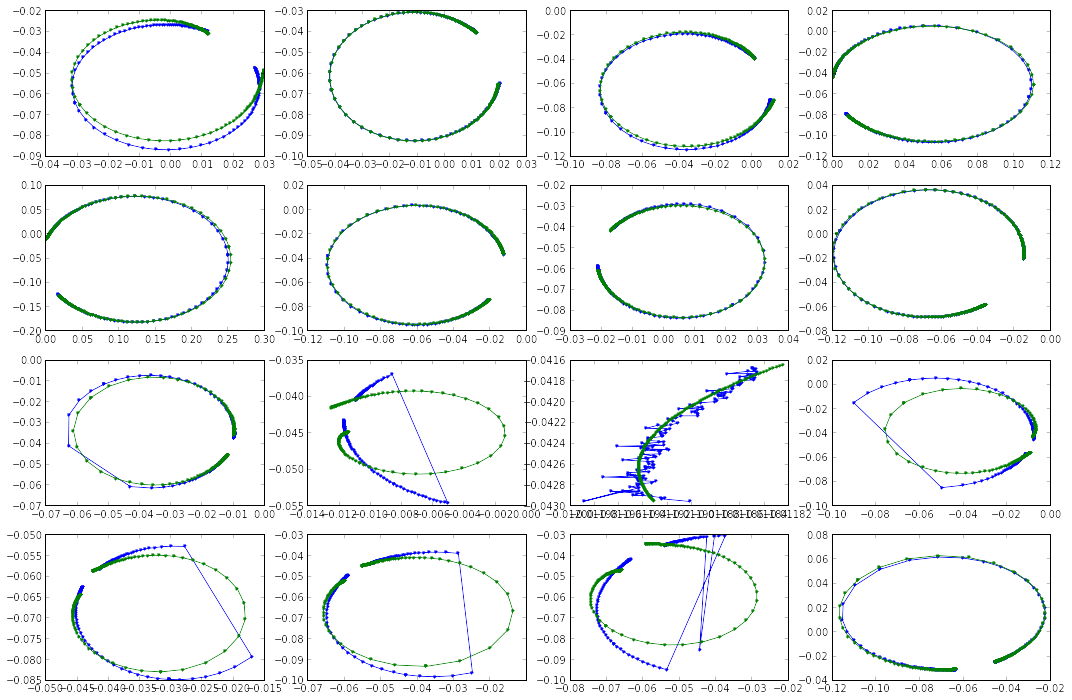

In [23]:
sweeps = []
for atten in atten_levels:
    ri.set_dac_atten(atten)
    print "atten",atten
    tic = time.time()
    fine_swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=16)
    print time.time()-tic
    sweeps.append(fine_swp)
    data_file.add_sweep(fine_swp)
    resonators = fit_sweeps(fine_swp)
    fit_f0s = np.array([res.f_0 for res in resonators])
    print "difference in resonant frequency, ppm:",(1e6*(new_f0s-fit_f0s)/new_f0s)
    ri.select_bank(ri.tone_bins.shape[0]-1)
    ri.select_fft_bins(range(ri.fft_bins.shape[1]))
    ri._sync()
    time.sleep(1)
    t0 = time.time()
    d,addr = ri.get_data(128)
    tsg = data_file.add_timestream_data(d,ri,t0)
    print time.time()-tic

In [24]:
data_file.close()

In [25]:
import kid_readout.analysis.iqnoise
import kid_readout.utils.despike

using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10


/home/gjones/readout/kid_readout/kid_readout/analysis/iqnoise.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  S[0,k] = ss[0,0]
/home/gjones/readout/kid_readout/kid_readout/analysis/iqnoise.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  S[1,k] = ss[1,1]


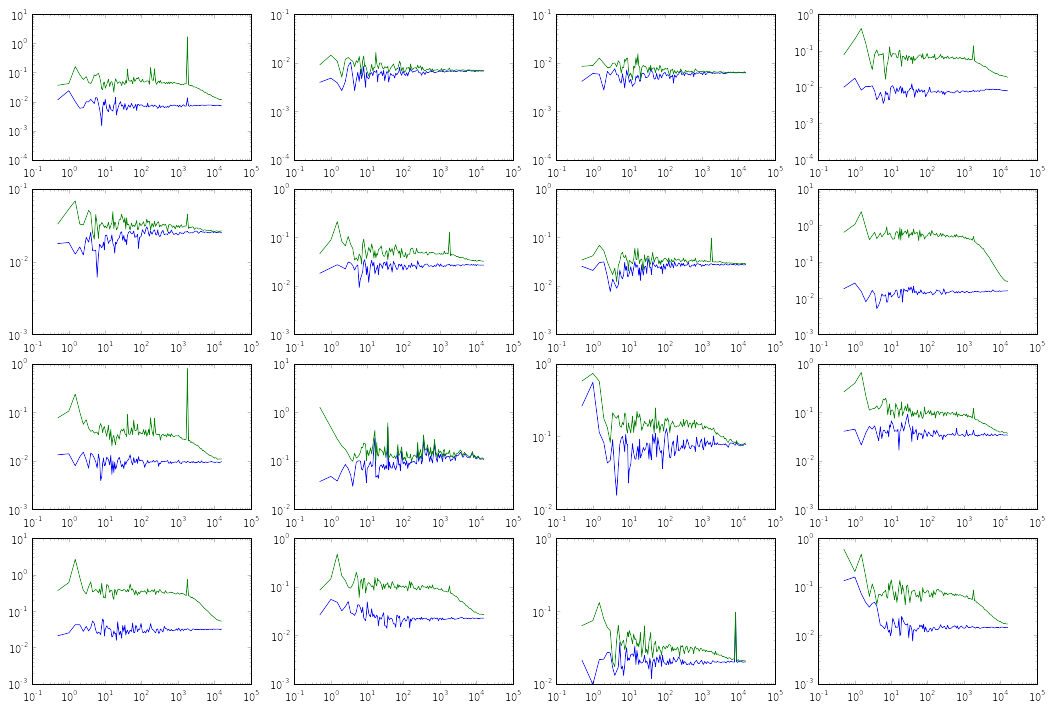

In [26]:
dmod=d
fig,axs = subplots(4,4,figsize=(18,12))
for k in range(16):
    ax = axs.flatten()[k]
    despike = kid_readout.utils.despike.deglitch_window(dmod[:,k]-dmod[:,k].mean(),2**14)
    fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(despike,Fs=512e6/2**14)
    ax.loglog(fr,evals.T)

In [30]:
ri.tone_bins.shape

(129, 16)

In [ ]:
new_res = fit_sweeps(fine_swp)

In [46]:
fr,s21,err = fine_swp.select_index(0)
fr.ptp()

0.1240234375

In [47]:
new_f0s = np.array([res.f_0 for res in new_res])
newQs = np.array([res.Q for res in new_res])
fwhm = new_f0s/(2*newQs)
(new_f0s - initial_f0s)*1e3

array([ -2.75036198,  -8.36499499, -18.1566517 ,  27.45684   ,
        29.52417282,   6.18154885,  62.34624514,  -7.40309064,
        44.37014026,  -3.04533981,  11.30370433, -10.9906153 ,
        13.04140384, -44.33065046,  19.85448771,   7.9253936 ])

In [48]:
fwhm

array([ 0.02912425,  0.03078778,  0.02714933,  0.0302079 ,  0.02514165,
        0.02601062,  0.03599471,  0.02899567,  0.02582677,  0.02677329,
        0.03062127,  0.03108903,  0.01615045,  0.01502604,  0.01341793,
        0.01315327])

In [49]:
[res.delay for res in new_res]

[0.45141720942144958,
 0.094586777665206123,
 0.014686151981272174,
 0.017796887808216814,
 0.00043724074656971993,
 0.011191579245233058,
 0.0094185496420942927,
 0.05758960001641613,
 -0.0033176609419354351,
 0.007291893632622024,
 0.0079508120551642324,
 -0.00077998325721197539,
 0.0041570727965430238,
 0.00093343481198936889,
 -0.00047656048102172777,
 0.011198239856341578]

In [50]:
newQs

array([ 14505.90628717,  14051.54439249,  16057.1507388 ,  14488.21970183,
        17494.86702526,  16935.31803672,  12267.80757015,  15367.16899379,
        17442.06407264,  16906.71882743,  14983.23560798,  14786.38738301,
        29272.02800418,  31527.12783064,  35416.04611583,  36629.2168434 ])

In [51]:
Qs

array([ 14512.79042247,  13616.48574293,  15691.05110949,  14375.85548433,
        17343.44571994,  17473.09661493,  12115.91118983,  15196.59562753,
        17542.05628817,  16683.89496554,  14765.47493265,  14619.13718965,
        27945.16383875,  29094.679821  ,  33561.02764402,  34569.66638804])

In [52]:
new_f0s

array([ 844.94724964,  865.23163501,  871.88184335,  875.31745684,
        879.69952417,  880.99618155,  883.15234625,  891.16259691,
        900.94437014,  905.29695466,  917.6113037 ,  919.38900938,
        945.5130414 ,  947.45566935,  950.41985449,  963.58792539])

In [53]:
ri.set_tone_freqs(new_f0s,nsamp=2**18)

bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([ 844.94726562,  865.23242188,  871.8828125 ,  875.31835938,
        879.69921875,  880.99609375,  883.15234375,  891.16210938,
        900.9453125 ,  905.296875  ,  917.61132812,  919.38867188,
        945.51367188,  947.45507812,  950.41992188,  963.58789062])

In [55]:
ri.select_fft_bins(range(16))

In [64]:
ri.set_dac_atten(10)

In [65]:
dmod,addr = ri.get_data(128)

detected mcnt overflow None 1310485 0 32768 0 26224 1310485


In [57]:
dmod.shape

(524288, 16)

In [26]:
import kid_readout.analysis.iqnoise
import kid_readout.utils.despike

In [30]:
dmod = d

using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10


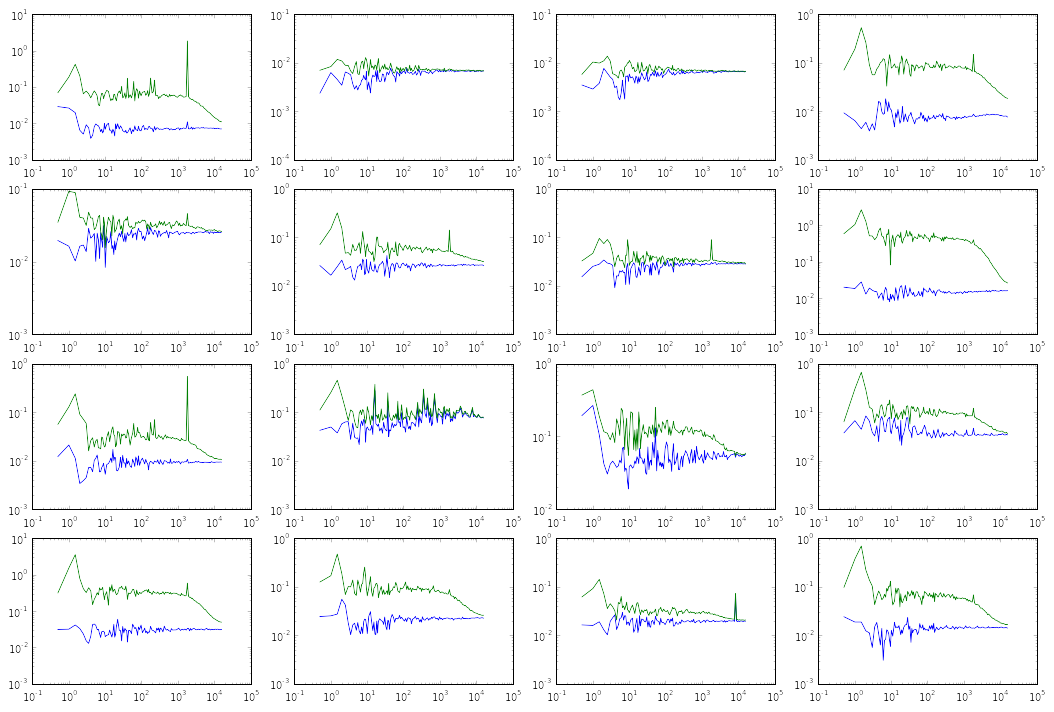

In [31]:
fig,axs = subplots(4,4,figsize=(18,12))
for k in range(16):
    ax = axs.flatten()[k]
    despike = kid_readout.utils.despike.deglitch_window(dmod[:,k]-dmod[:,k].mean(),2**14)
    fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(despike,Fs=512e6/2**14)
    ax.loglog(fr,evals.T)
#    ax.xaxis.set_scale('symlog')

In [76]:
ts = dmod[:,3]
despike = kid_readout.utils.despike.deglitch_window(dmod[:,3]-dmod[:,3].mean(),2**14)

In [79]:
Qs

array([ 14512.79042247,  13616.48574293,  15691.05110949,  14375.85548433,
        17343.44571994,  17473.09661493,  12115.91118983,  15196.59562753,
        17542.05628817,  16683.89496554,  14765.47493265,  14619.13718965,
        27945.16383875,  29094.679821  ,  33561.02764402,  34569.66638804])

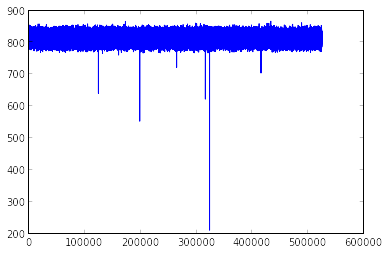

In [68]:
plot(np.abs(ts))

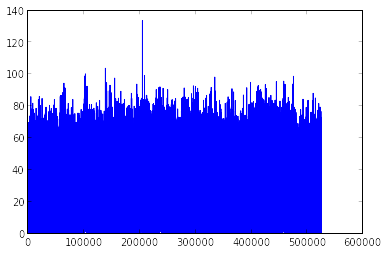

In [74]:
plot(np.abs(despike))

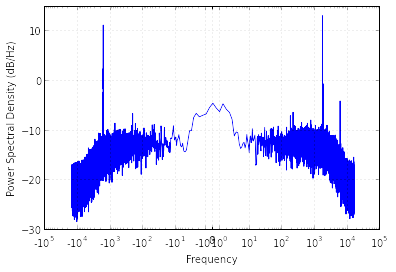

In [77]:
blah = psd(despike,NFFT=2**16,Fs=512e6/2**14)
xscale('symlog')

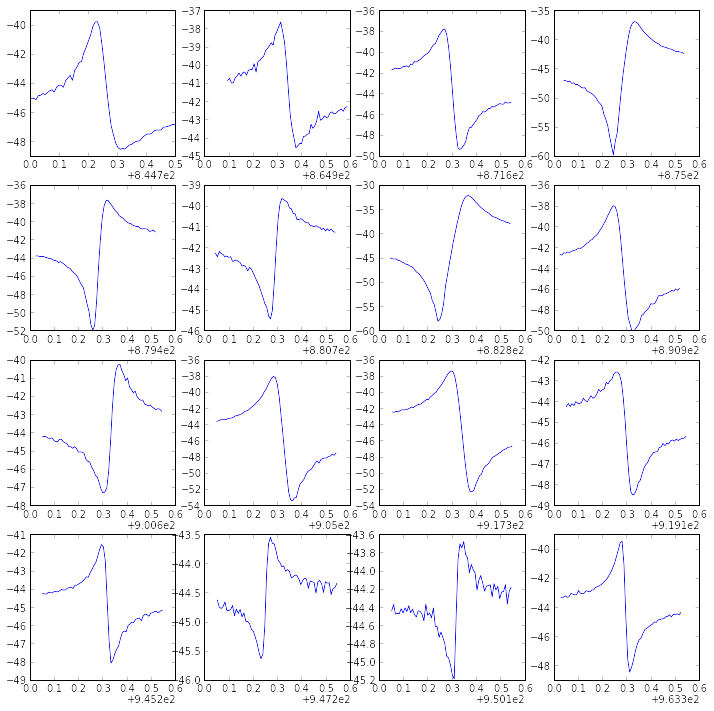

In [124]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    ax.plot(fr,20*np.log10(np.abs(s21)))

In [125]:
import kid_readout.analysis.resonator
import kid_readout.analysis.khalil

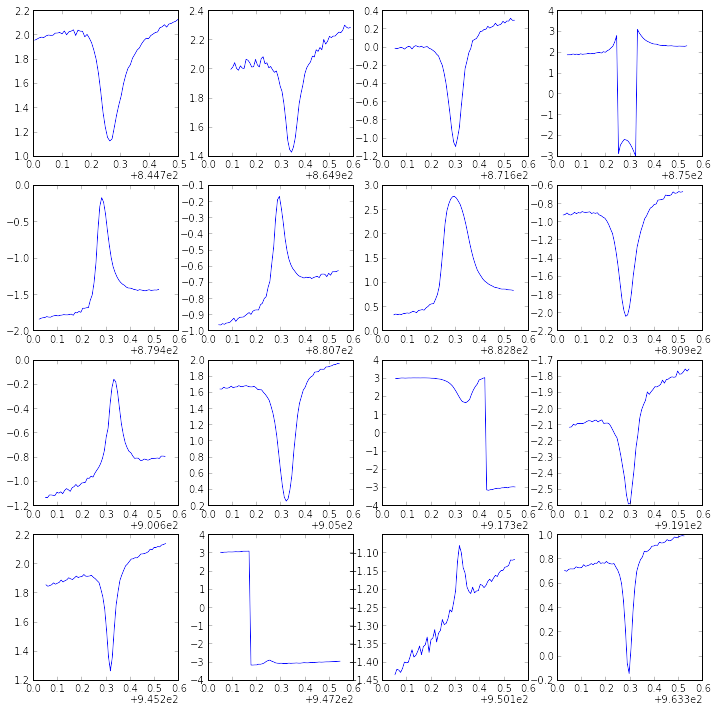

In [126]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.2j*2*np.pi*(fr-ri.lo_frequency))
    ax.plot(fr,np.angle(s21c))

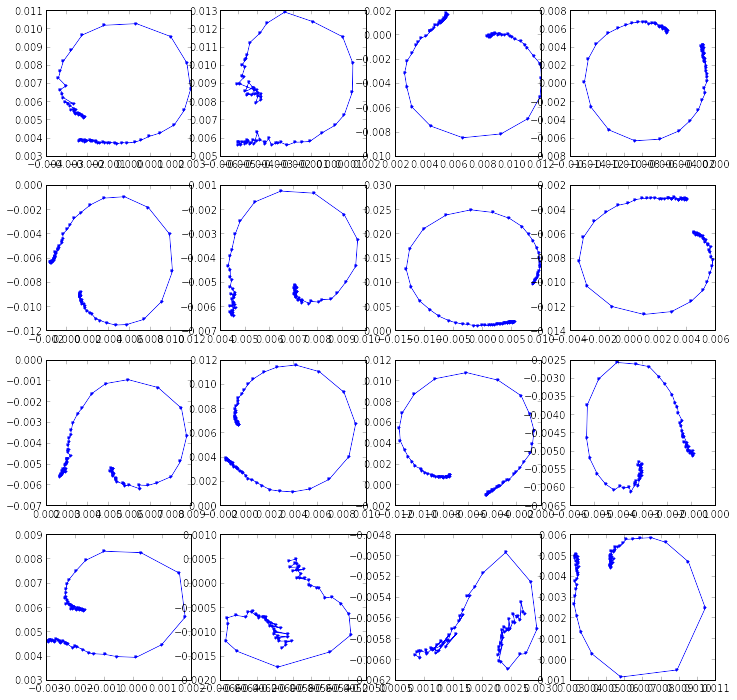

In [127]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.2j*2*np.pi*(fr-ri.lo_frequency))
    ax.plot(s21c.real,s21c.imag,'.-')

845.1953125 844.703125
14509.7893985 14510.444072 0.472129867535 -12322.2285727 0.0800919642239
865.484375 864.9921875
13217.4273966 13217.884756 0.760819793999 -17047.7298542 0.0100592267738
872.140625 871.6484375
15307.4575411 16953.022477 783.67883999 -11089.3188141 0.000493518101752
875.53125 875.0390625
13887.2248591 31777.5032586 1563.03520456 6009.36525281 0.0160531714692
879.9140625 879.421875
16758.0974406 29862.4133242 3680.38495625 11269.6055095 0.00194483158019
881.234375 880.7421875
16811.7420033 20299.9183079 7482.62873315 26001.8731006 0.00126192586539
883.3359375 882.84375
11713.1545005 28560.3193672 898.400288419 4127.01665023 -0.00358999245783
891.4140625 890.921875
14772.6694893 14773.5314117 0.368098003745 -9654.26705551 0.0142959632228
901.140625 900.6484375
16935.1407938 17823.343019 1244.08575013 20523.9908142 -0.00552956651021
905.5390625 905.046875
16206.3700044 18077.653404 444.903903596 -8334.11105078 0.00199650798053
917.84375 917.3515625
14529.9086211 16900

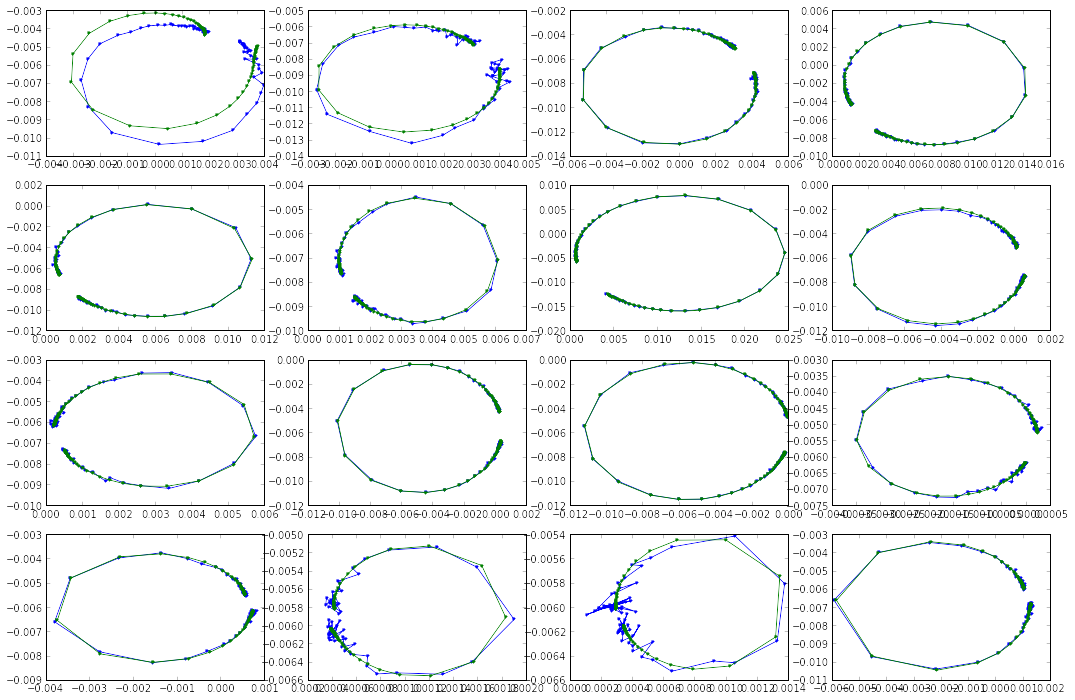

In [132]:
fig,axs = subplots(4,4,figsize=(18,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.3j*2*np.pi*(fr-ri.lo_frequency))
    print fr.max(),fr.min()
    res = kid_readout.analysis.resonator.fit_best_resonator(fr,s21c,errors=err,min_a=1.0)
    ax.plot(s21c.real,s21c.imag,'.-')
    modl = res.model(x=fr)
    ax.plot(modl.real,modl.imag,'.-')
    print res.Q,res.Q_i,res.Q_e_real,res.Q_e_imag,res.delay
    try:
        ax.set_title(str(res.a))
    except:
        pass

879.9140625 879.421875
16824.6691064 30191.5952085 3740.63904884 11320.6719853 -0.000457328720674


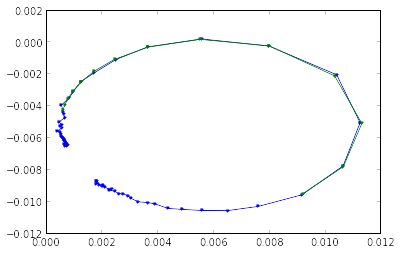

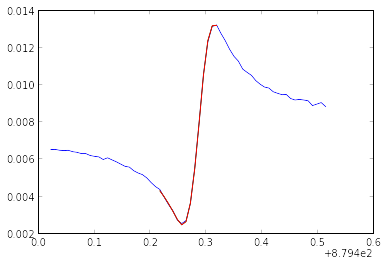

In [129]:
ax = gca()
fr,s21,err = swp.select_index(4)
s21c = s21*np.exp(-31.3j*2*np.pi*(fr-ri.lo_frequency))
print fr.max(),fr.min()
res = kid_readout.analysis.resonator.fit_best_resonator(fr[25:-25],s21c[25:-25],errors=err[25:-25],min_a=1.0)
ax.plot(s21c.real,s21c.imag,'.-')
modl = res.model(x=res.freq_data)
ax.plot(modl.real,modl.imag,'.-')
print res.Q,res.Q_i,res.Q_e_real,res.Q_e_imag,res.delay
figure()
plot(fr,np.abs(s21c))
plot(res.freq_data,np.abs(modl))
plot(res.freq_data,np.abs(res.model(x=res.freq_data)))


In [96]:
1/(1/res.Q-1/np.abs(res.Q_e_real+1j*res.Q_e_imag))

36322.665100510239

In [97]:
res.Q

13711.847040231984

In [98]:
res.Q_i

15899.183778596402

In [41]:
blks = [blk for blk in swp.blocks if blk.sweep_index==2]

In [42]:
blk = blks[0]

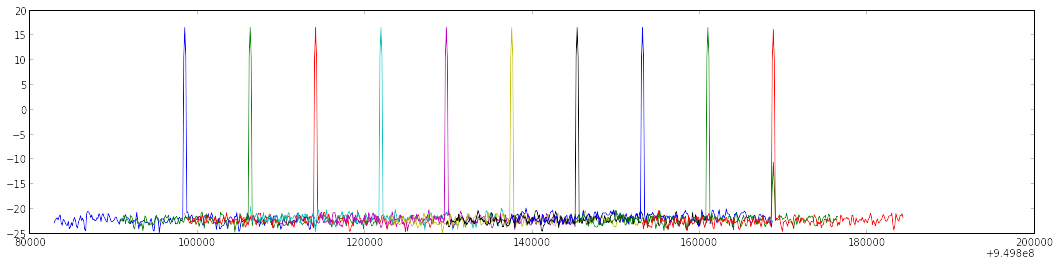

In [52]:
figure(figsize=(18,4))
for blk in blks[:10]:
    pxx,frl = mlab.psd(blk.data,Fs=512e6/2**14)
    f1 = blk.tone*512e6/blk.nsamp
    plot(frl+f1+930e6,10*np.log10(pxx))

In [48]:
len(blks)

128

In [53]:
by_index = [[blk for blk in swp.blocks if blk.sweep_index==k] for k in range(16)]

(944000000.0, 951000000.0)

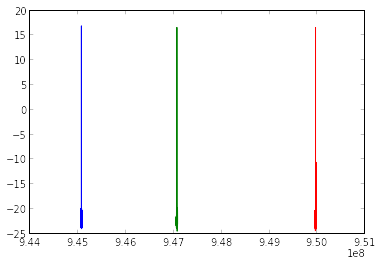

In [58]:
for idx in range(16):
    blk = by_index[idx][8]
    pxx,frl = mlab.psd(blk.data,Fs=512e6/2**14)
    f1 = blk.tone*512e6/blk.nsamp
    plot(frl+f1+930e6,10*np.log10(pxx))
xlim(944e6,951e6)

In [60]:
fr,s21,err = swp.select_index(2)

In [61]:
fr.min()

949.8984375

In [62]:
initial_f0s[14:15]

array([ 950.4])

In [63]:
nsamp = 2**16
df = 512./nsamp
kid_readout.utils.sweeps.prepare_sweep(ri,center_freqs=initial_f0s[14:15],offsets=np.arange(-64,64)*df,
                                       nsamp=nsamp)


bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([[ 949.8984375],
       [ 949.90625  ],
       [ 949.9140625],
       [ 949.921875 ],
       [ 949.9296875],
       [ 949.9375   ],
       [ 949.9453125],
       [ 949.953125 ],
       [ 949.9609375],
       [ 949.96875  ],
       [ 949.9765625],
       [ 949.984375 ],
       [ 949.9921875],
       [ 950.       ],
       [ 950.0078125],
       [ 950.015625 ],
       [ 950.0234375],
       [ 950.03125  ],
       [ 950.0390625],
       [ 950.046875 ],
       [ 950.0546875],
       [ 950.0625   ],
       [ 950.0703125],
       [ 950.078125 ],
       [ 950.0859375],
       [ 950.09375  ],
       [ 950.1015625],
       [ 950.109375 ],
       [ 950.1171875],
       [ 950.125    ],
       [ 950.1328125],
       [ 950.140625 ],
       [ 950.1484375],
       [ 950.15625  ],
       [ 950.1640625],
       [ 950.171875 ],
       [ 950.1796875],
       [ 950.1875   ],
       [ 950.1953125],
       [ 950.203125 ],
       [ 950.2109375],
       [ 950.21875  ],
       [ 950.2265625],
       [ 95

In [70]:
ri.set_dac_atten(40)

In [71]:
tic = time.time()
swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=1)
print time.time()-tic

detected mcnt overflow None 22667977 0 2048 0 16 22667977
55.4558930397


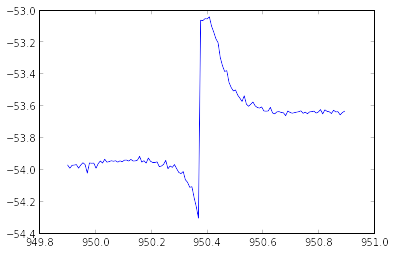

In [72]:
plot(swp.freqs,20*np.log10(np.abs(swp.data)))